In [1]:
import numpy as np
import simpy
import random

In [2]:
conveyor_length = 10

In [3]:
test_conveyort = np.zeros(conveyor_length)

In [4]:
test_conveyort

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
import simpy
import yaml
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque

# -------------- CONFIGURATION READER --------------
def load_config(path="config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

# -------------- MODULAR COMPONENTS --------------

class ConveyorBelt:
    def __init__(self, env, name, capacity, speed):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.speed = speed
        self.store = simpy.Store(env, capacity=capacity)
        self.in_transit = deque(maxlen=capacity)
        self.history = []

    def put(self, item):
        self.in_transit.append(self.env.now)
        return self.store.put(item)

    def get(self):
        yield self.env.timeout(1.0 / self.speed)
        self.in_transit.popleft()
        item = yield self.store.get()
        return item

    def utilization(self):
        return len(self.store.items) / self.capacity

    def is_bottleneck(self):
        return len(self.store.items) >= self.capacity

class Buffer:
    def __init__(self, env, name, capacity):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.store = simpy.Store(env, capacity=capacity)

    def put(self, item):
        return self.store.put(item)

    def get(self):
        item = yield self.store.get()
        return item

    def utilization(self):
        return len(self.store.items) / self.capacity

    def is_bottleneck(self):
        return len(self.store.items) >= self.capacity

class Machine:
    def __init__(self, env, name, capacity, speed):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.speed = speed
        self.busy = False

    def process(self, input_store, output_store):
        while True:
            self.busy = True
            items = []
            for _ in range(self.capacity):
                try:
                    item = yield input_store.get()
                    items.append(item)
                except simpy.exceptions.Empty:
                    break
            if items:
                yield self.env.timeout(1.0 / self.speed)
                for item in items:
                    yield output_store.put(item)
            else:
                yield self.env.timeout(0.1)
            self.busy = False

class Storage:
    def __init__(self, env, capacity):
        self.env = env
        self.capacity = capacity
        self.store = simpy.Store(env, capacity=capacity)

    def put(self, item):
        return self.store.put(item)

    def get(self):
        item = yield self.store.get()
        return item

# -------------- SIMULATION ENVIRONMENT --------------

class AssemblyLine:
    def __init__(self, config):
        self.env = simpy.Environment()
        self.config = config
        # Funnel (acts as the initial source)
        self.funnel = simpy.Store(self.env, capacity=config['funnel']['capacity'])
        for i in range(config['target_bottles']):
            self.funnel.put(f"raw_material_{i}")

        # Conveyor belts
        self.conv = {k: ConveyorBelt(self.env, k, **v)
                     for k, v in config['conveyor_belts'].items()}
        # Buffers
        self.buffer = {k: Buffer(self.env, k, **v)
                       for k, v in config['buffers'].items()}
        # Machines
        self.machines = {
            'blow':  Machine(self.env, 'blow',  config['machines']['blow']['capacity'], config['machines']['blow']['speed']),
            'clean': Machine(self.env, 'clean', config['machines']['clean']['capacity'], config['machines']['clean']['speed']),
            'wrap':  Machine(self.env, 'wrap',  config['machines']['wrap']['capacity'], config['machines']['wrap']['speed'])
        }
        # Storage, robotic arm, platform
        self.storage = Storage(self.env, config['storage']['capacity'])
        self.platform = simpy.Store(self.env, capacity=config['platform']['capacity'])

        # History for visualization
        self.history = {name: [] for name in
            ['funnel', *self.conv.keys(), *self.buffer.keys(), 'storage', 'platform']}

    def run(self):
        env = self.env
        config = self.config

        def source():
            while True:
                if len(self.funnel.items) > 0:
                    item = yield self.funnel.get()
                    yield self.conv['conv1'].put(item)
                else:
                    break
                yield env.timeout(0.01) # slight pause to avoid instant transfer

        def transfer(name, from_store, to_store):
            while True:
                item = yield from_store.get()
                yield to_store.put(item)
                yield env.timeout(0.01)

        # Set up processes for each stage in the assembly line
        env.process(source())
        env.process(transfer('conv1->blow', self.conv['conv1'].store, self.conv['conv1'].store)) # For smoothness
        env.process(self.machines['blow'].process(self.conv['conv1'].store, self.conv['conv2'].store))
        env.process(transfer('conv2->buffer1', self.conv['conv2'].store, self.buffer['buffer1'].store))
        env.process(transfer('buffer1->conv3', self.buffer['buffer1'].store, self.conv['conv3'].store))
        env.process(self.machines['clean'].process(self.conv['conv3'].store, self.conv['conv4'].store))
        env.process(transfer('conv4->buffer2', self.conv['conv4'].store, self.buffer['buffer2'].store))
        env.process(transfer('buffer2->conv5', self.buffer['buffer2'].store, self.conv['conv5'].store))
        env.process(self.machines['wrap'].process(self.conv['conv5'].store, self.conv['conv6'].store))
        env.process(transfer('conv6->storage', self.conv['conv6'].store, self.storage.store))
        env.process(transfer('storage->platform', self.storage.store, self.platform))

        # For visualization
        def record_history():
            while True:
                self.history['funnel'].append(len(self.funnel.items))
                for name, c in self.conv.items():
                    self.history[name].append(len(c.store.items))
                for name, b in self.buffer.items():
                    self.history[name].append(len(b.store.items))
                self.history['storage'].append(len(self.storage.store.items))
                self.history['platform'].append(len(self.platform.items))
                yield env.timeout(1)
        env.process(record_history())

    def simulate(self, until=100):
        self.run()
        self.env.run(until=until)

    def get_history(self):
        return self.history

# -------------- VISUALIZATION --------------

def animate_buffers(history, config):
    stages = list(history.keys())
    fig, ax = plt.subplots(figsize=(12,6))
    bars = ax.bar(stages, [0]*len(stages), color='b')

    def update(i):
        for idx, stage in enumerate(stages):
            val = history[stage][i]
            cap = config['funnel']['capacity'] if stage == 'funnel' else \
                  config['platform']['capacity'] if stage == 'platform' else \
                  config['storage']['capacity'] if stage == 'storage' else \
                  config['buffers'][stage]['capacity'] if stage in config['buffers'] else \
                  config['conveyor_belts'][stage]['capacity'] if stage in config['conveyor_belts'] else 1
            bars[idx].set_height(val)
            # Highlight red if bottleneck
            if val >= cap:
                bars[idx].set_color('r')
            else:
                bars[idx].set_color('b')
        ax.set_ylim(0, max([max(h) for h in history.values()])+5)
        ax.set_ylabel("Items in Buffer/Store")
        ax.set_title(f"Assembly Line Buffer Visualization (t={i})")

    ani = animation.FuncAnimation(fig, update, frames=len(next(iter(history.values()))), repeat=False, interval=200)
    plt.show()


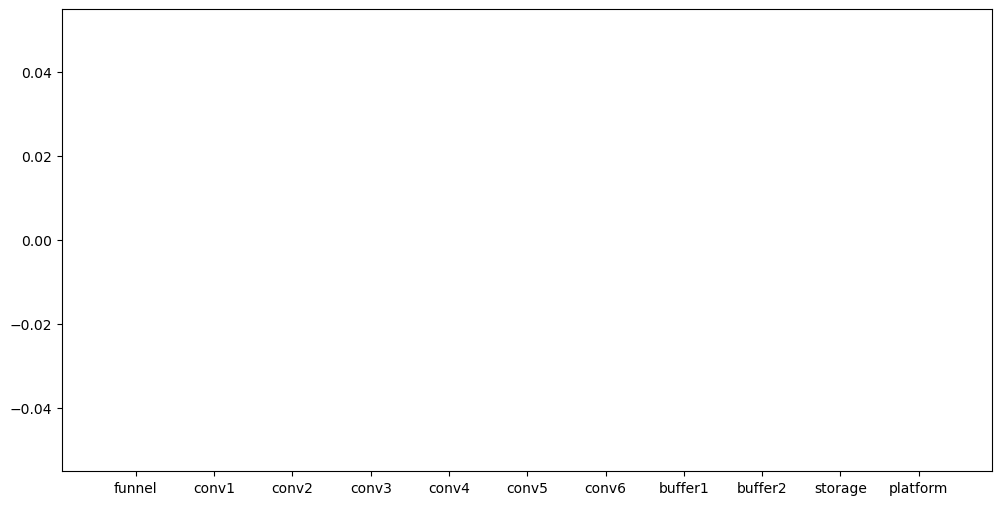

/home/aipexws1/miniconda3/envs/agilestem/lib/python3.9/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [8]:
config = load_config("config.yaml")
line = AssemblyLine(config)
line.simulate(until=80)
history = line.get_history()
animate_buffers(history, config)

In [ ]:
class ConveyorBelt():
    """
    ConveyorBelt simulates a physical conveyor belt using a numpy array.
    Items move through discrete positions on the belt based on speed.
    """
    def __init__(self, env, name, capacity, input_buffer, output_buffer, conv_time_config, fall_off_prob=0.0):
        self.env = env
        self.input_buffer = input_buffer
        self.output_buffer = output_buffer
        self.name = name
        
        # Physical belt representation
        self.belt_length = capacity  # Number of positions on belt
        self.belt = np.zeros(self.belt_length, dtype=int)  # 0=empty, 1=item
        self.item_ages = np.zeros(self.belt_length, dtype=float)  # Track how long items have been on belt
        
        # Speed and timing
        if isinstance(conv_time_config, dict):
            self.base_conveyor_time = conv_time_config.get('base', 2.0)
            self.min_conveyor_time = conv_time_config.get('min', 0.5)
            self.max_conveyor_time = conv_time_config.get('max', 10.0)
        else:
            self.base_conveyor_time = conv_time_config
            self.min_conveyor_time = conv_time_config * 0.5
            self.max_conveyor_time = conv_time_config * 2.0
        
        self.conveyor_time = self.base_conveyor_time
        self.speed_factor = 1.0
        self.move_interval = self.conveyor_time / self.belt_length  # Time between belt movements
        
        # Statistics
        self.bottle_fall_off_prob = fall_off_prob
        self.transported_items = 0
        self.fall_off_count = 0
        self.wait_times = []
        self.idle_time = 0
        self.blocked_time = 0
        self.total_transport_time = 0
        
        # State tracking
        self.is_busy = False
        self.is_blocked = False
        self.last_idle_start = 0
    
    def process(self, env):
        # Start both processes
        self.input_proc = env.process(self.input_handler())
        self.belt_proc = env.process(self.belt_mover())
    
    def input_handler(self):
        """Handle getting items from input buffer and placing on belt"""
        while True:
            # Wait for item and belt space
            idle_start = self.env.now
            item = yield self.input_buffer.get()
            
            # Wait for space at belt entrance (position 0)
            while self.belt[0] != 0:
                yield self.env.timeout(0.01)
            
            # Place item on belt
            self.belt[0] = 1
            self.item_ages[0] = self.env.now
            
            # Track statistics
            wait_time = self.env.now - idle_start
            self.wait_times.append(wait_time)
            self.idle_time += wait_time
            self.is_busy = np.any(self.belt > 0)
    
    def belt_mover(self):
        """Move belt contents to the right at regular intervals"""
        while True:
            yield self.env.timeout(self.move_interval)
            
            # Check if last position has item (needs to be output)
            if self.belt[-1] == 1:
                # Try to output item
                if len(self.output_buffer.items) < self.output_buffer.capacity:
                    # Successfully output
                    yield self.output_buffer.put(1)
                    self.transported_items += 1
                    transport_time = self.env.now - self.item_ages[-1]
                    self.total_transport_time += transport_time
                    
                    # Shift belt
                    self.belt[1:] = self.belt[:-1]
                    self.belt[0] = 0
                    self.item_ages[1:] = self.item_ages[:-1]
                    self.item_ages[0] = 0
                else:
                    # Blocked - higher chance of fall-off
                    if random.random() < self.bottle_fall_off_prob * 2.0:
                        print(f"Bottle fell off conveyor {self.name} at time {self.env.now}")
                        self.fall_off_count += 1
                        # Shift belt anyway
                        self.belt[1:] = self.belt[:-1]
                        self.belt[0] = 0
                        self.item_ages[1:] = self.item_ages[:-1]
                        self.item_ages[0] = 0
                    else:
                        # Stay blocked, don't move belt
                        self.is_blocked = True
                        continue
            else:
                # Normal belt movement
                self.belt[1:] = self.belt[:-1]
                self.belt[0] = 0
                self.item_ages[1:] = self.item_ages[:-1]
                self.item_ages[0] = 0
            
            # Check for random fall-offs during transport
            for i in range(1, len(self.belt)):
                if self.belt[i] == 1 and random.random() < self.bottle_fall_off_prob:
                    print(f"Bottle fell off conveyor {self.name} at position {i} at time {self.env.now}")
                    self.belt[i] = 0
                    self.item_ages[i] = 0
                    self.fall_off_count += 1
            
            # Update state
            self.is_busy = np.any(self.belt > 0)
            self.is_blocked = False
    
    def set_speed(self, speed_factor):
        """Adjust conveyor speed"""
        self.speed_factor = max(0.1, min(speed_factor, 3.0))
        self.conveyor_time = self.base_conveyor_time / self.speed_factor
        self.conveyor_time = max(self.min_conveyor_time, min(self.conveyor_time, self.max_conveyor_time))
        self.move_interval = self.conveyor_time / self.belt_length
    
    def get_stats(self):
        """Return comprehensive conveyor statistics"""
        items_on_belt = np.sum(self.belt)
        avg_wait = sum(self.wait_times) / len(self.wait_times) if self.wait_times else 0
        
        return {
            'name': self.name,
            'transported_items': self.transported_items,
            'fall_off_count': self.fall_off_count,
            'items_in_transit': items_on_belt,
            'belt_state': self.belt.tolist(),
            'utilization': (self.total_transport_time / self.env.now * 100) if self.env.now > 0 else 0,
            'throughput': self.transported_items / self.env.now if self.env.now > 0 else 0,
            'efficiency': (self.transported_items / (self.transported_items + self.fall_off_count) * 100) if (self.transported_items + self.fall_off_count) > 0 else 100,
            'avg_wait_time': avg_wait,
            'total_idle_time': self.idle_time,
            'total_blocked_time': self.blocked_time,
            'is_busy': self.is_busy,
            'is_blocked': self.is_blocked,
            'current_speed_factor': self.speed_factor,
            'current_conveyor_time': self.conveyor_time
        }

In [11]:
import simpy

def conveyor_belt(env, belt, move_interval):
    while True:
        yield env.timeout(move_interval)
        # Move items forward
        for i in reversed(range(1, len(belt))):
            belt[i] = belt[i-1]
        belt[0] = None  # New slot at the start
        print(f'Time {env.now}: Belt state: {belt}')

def item_process(env, belt, start_slot, process_time):
    # Wait until the item reaches the desired slot
    while belt[start_slot] is None:
        yield env.timeout(1)
    # Process the item
    yield env.timeout(process_time)
    print(f'Time {env.now}: Item at slot {start_slot} processed')

env = simpy.Environment()
belt = [None] * 5  # 5-slot conveyor belt
env.process(conveyor_belt(env, belt, move_interval=2))
# Add item to the belt at slot 0
belt[0] = 'Box1'
env.process(item_process(env, belt, start_slot=2, process_time=3))
env.run(until=20)

Time 2: Belt state: [None, 'Box1', None, None, None]
Time 4: Belt state: [None, None, 'Box1', None, None]
Time 6: Belt state: [None, None, None, 'Box1', None]
Time 7: Item at slot 2 processed
Time 8: Belt state: [None, None, None, None, 'Box1']
Time 10: Belt state: [None, None, None, None, None]
Time 12: Belt state: [None, None, None, None, None]
Time 14: Belt state: [None, None, None, None, None]
Time 16: Belt state: [None, None, None, None, None]
Time 18: Belt state: [None, None, None, None, None]
